In [1]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
import dask_xgboost as dxgb
from dask_ml import datasets
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
params = {
    'objective': 'binary:logistic', 
    'n_estimators': 420,
    'max_depth': 5, 
    'eta': .01,
    'subsample': 1, 
    'nthread': 1,
    'colsample_bytree': 1,
    'learning_rate': .05, 
    'scale_pos_weight': 1,
    'tree_method': 'exact',
    'seed': 123,
    'nthread': 1,
}

In [3]:
cluster = LocalCluster(n_workers=6, threads_per_worker=1)

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:55166 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 17.18 GB


In [5]:
cluster.scale(4)

In [6]:
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=12)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train) 

# DMLC Dask XGBoost

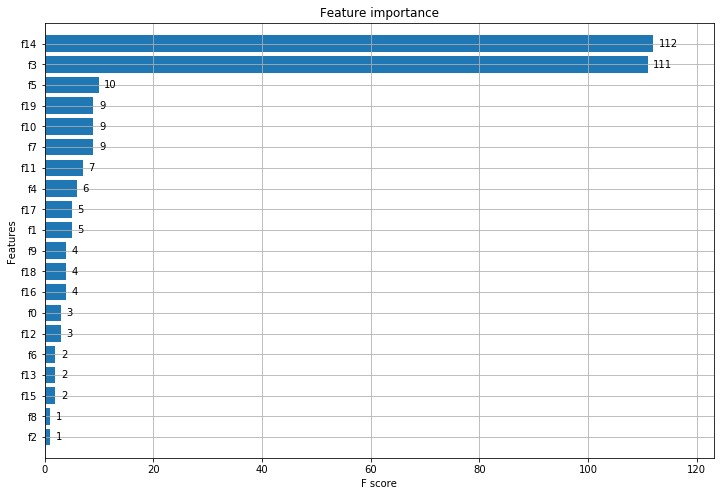

In [7]:
bst = xgb.dask.train(client, params, dtrain)['booster']

fig, ax = plt.subplots(figsize=(12, 8))
ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=len(X_train))
ax.grid(True, axis="y")

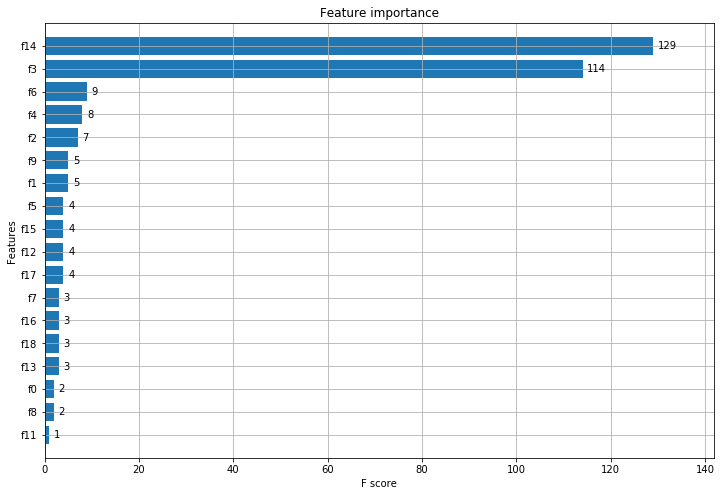

In [10]:
bst = xgb.dask.train(client, params, dtrain)['booster']

fig, ax = plt.subplots(figsize=(12, 8))
ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=len(X_train))
ax.grid(True, axis="y")

# Dask Distribtued XGBoost

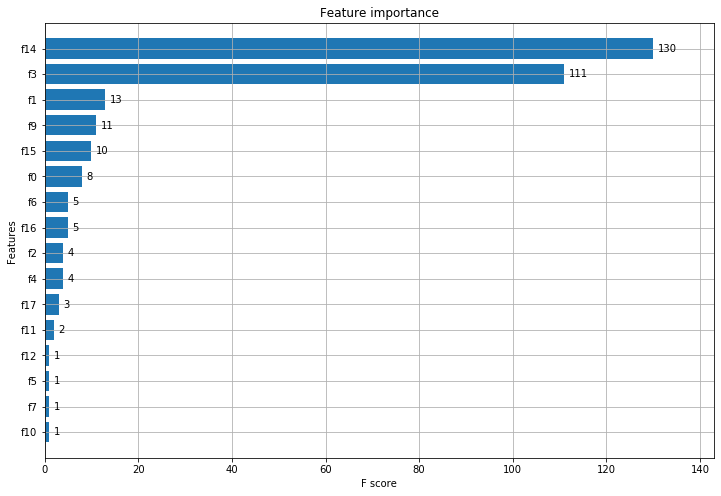

In [11]:
bst = dxgb.train(client, params, X_train, y_train)
bst

fig, ax = plt.subplots(figsize=(12, 8))
ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=len(X_train))
ax.grid(True, axis="y")

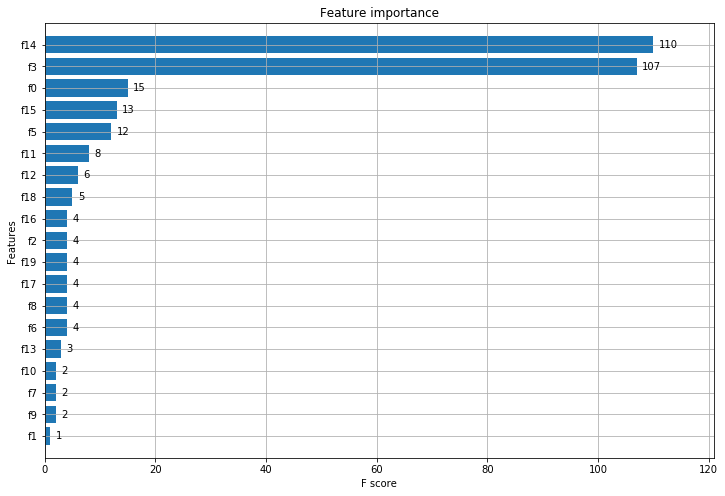

In [12]:
bst1 = dxgb.train(client, params, X_train, y_train)
fig, ax = plt.subplots(figsize=(12, 8))

ax1 = xgb.plot_importance(bst1, ax=ax, height=0.8, max_num_features=len(X_train))
ax1.grid(True, axis="y")

# Single Worker Dask-XGBoost

In [13]:
cluster.scale(1)

In [14]:
client

Client Scheduler: tcp://127.0.0.1:55166 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 2.86 GB


In [15]:
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

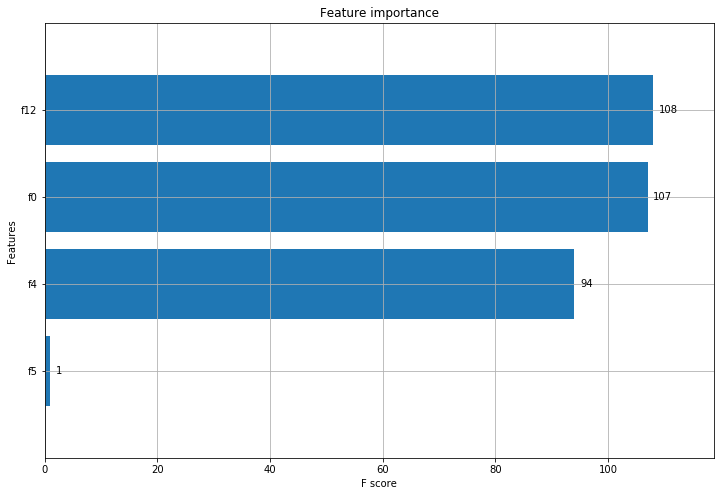

In [16]:
bst = dxgb.train(client, params, X_train, y_train)
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=len(X_train))
ax.grid(True, axis="y")

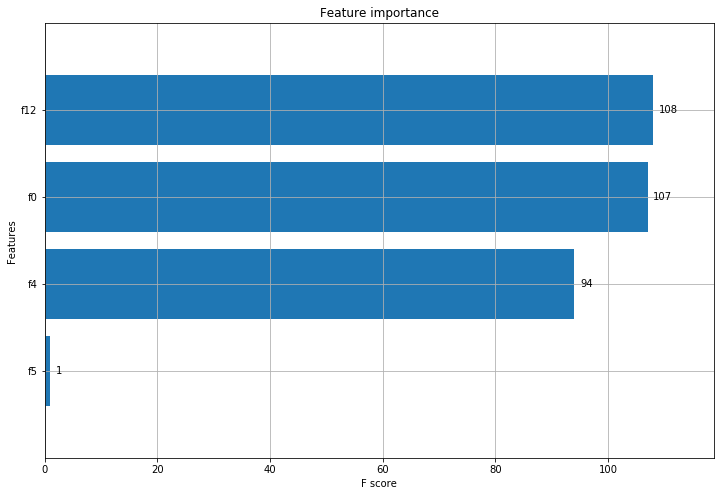

In [17]:
bst1 = dxgb.train(client, params, X_train, y_train)
fig, ax = plt.subplots(figsize=(12, 8))

ax1 = xgb.plot_importance(bst1, ax=ax, height=0.8, max_num_features=len(X_train))
ax1.grid(True, axis="y")

# XGBoost

In [18]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100000, n_features=20, n_informative=4,
                           random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
dtrain = xgb.DMatrix(data=X_train,label=y_train)

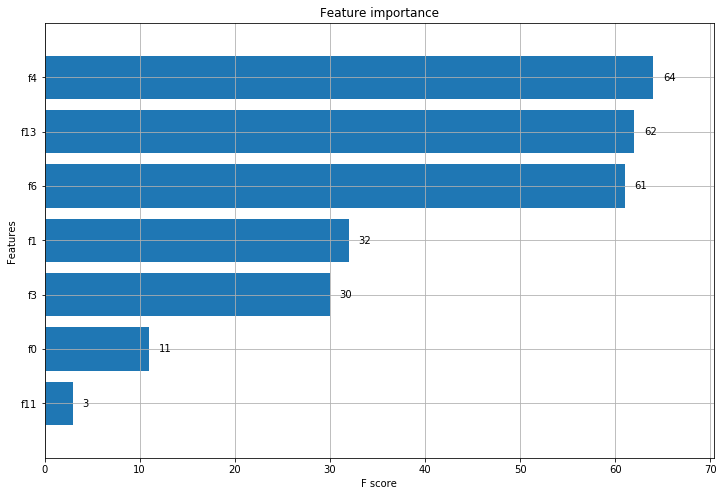

In [19]:
bst = xgb.train(params, dtrain)
fig, ax = plt.subplots(figsize=(12, 8))

ax1 = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=len(X_train))
ax1.grid(True, axis="y")

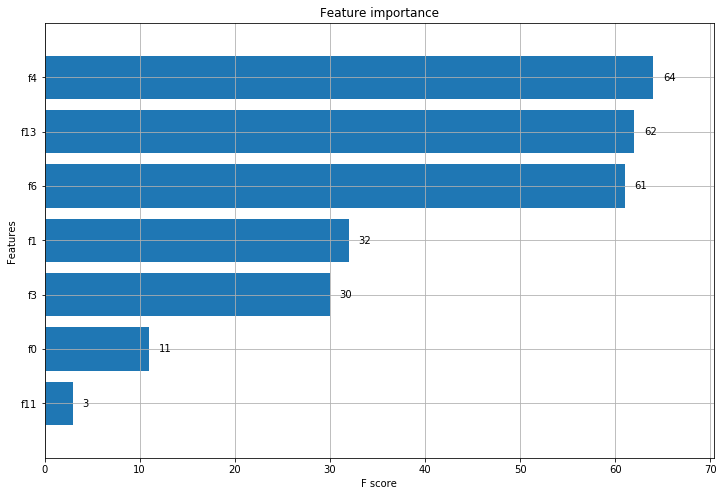

In [20]:
bst1 = xgb.train(params, dtrain)
fig, ax = plt.subplots(figsize=(12, 8))

ax1 = xgb.plot_importance(bst1, ax=ax, height=0.8, max_num_features=len(X_train))
ax1.grid(True, axis="y")